## **Zeroth-Order Optimization (ZOO) Attack and Binary Input Detector Using CIFAR-10**

This notebook demonstrates the implementation of the ZOO attack using the Adversarial Robustness Toolbox (ART) against deep learning models trained on the CIFAR-10 dataset. The tasks covered in this notebook are:

1. Load the Required Libraries

    The necessary Python libraries and modules are imported, including TensorFlow/Keras for model creation and ART for implementing the adversarial attack.

2. Load the Dataset and Inspect the Data

    The CIFAR-10 dataset, which consists of 60,000 color images in 10 classes, is loaded and inspected. This step includes visualizing sample images and understanding the data distribution.

3. Create a Deep Learning Model
    
    A ResNet-18 model is constructed to classify the CIFAR-10 images. ResNet-18, part of the Residual Network family, is chosen for its simplicity and effectiveness, featuring 18 layers including convolutional, batch normalization, and fully connected layers.

4. Train and Evaluate the Deep Learning Model on CIFAR-10 Test Data
    
    The ResNet-18 model is trained using the CIFAR-10 training set and subsequently evaluated on the test set to establish a baseline accuracy.

5. Implement ZOO Attack Using ART

    The Zeroth-Order Optimization (ZOO) Attack is implemented using the ART library. ZOO is an efficient black-box adversarial attack that perturbs images by iteratively flipping the sign of individual pixels and checking the impact on the model's prediction. The attack works by querying the model to observe changes in output and does not require access to the model's internal parameters or gradients.

More about ZOO:

The Zeroth Order Optimization (ZOO) attack is notable for its effectiveness in black-box settings, where only the model's output is accessible. The attack involves:

* Gradient Estimation: Estimating the gradient of the loss function with respect to the input by querying the model multiple times.
* Finite Difference Method: Using the finite difference method to approximate gradients by perturbing input pixels and observing changes in the output.
* Coordinate Descent: Updating one pixel at a time based on the estimated gradients to minimize the loss function and craft adversarial examples.
* Iterative Process: Repeating the process iteratively to generate adversarial samples that maximize the attack's success in causing misclassification with minimal perturbations.


6. Create Adversarial Samples Using the Z00 Attack

    Using the Z00 attack, adversarial examples are generated from the original test images. These adversarial samples are 
    visually inspected to compare them with the original images.

7. Evaluate the Deep Learning Model Against the Adversarial Samples

    The robustness of the trained CNN model is evaluated by testing its accuracy on the generated adversarial samples. This step highlights the model's vulnerability to adversarial attacks.

8. Create a Detector Model to Detect Adversarial Samples

    A binary classification model is developed to detect whether an input sample is adversarial or not. This involves designing a model that can differentiate between original and adversarial images based on specific features.

9. Train and Evaluate the Detector Model

    The detector model is trained using a labeled dataset containing both original and adversarial samples. The performance of the detector is then evaluated to determine its accuracy in identifying adversarial attacks.

----

This summary encapsulates the process and key tasks involved in implementing the ZOO attack and developing a binary input detector using the CIFAR-10 dataset. The addition of the Z00 attack illustrates an effective method to evaluate the robustness of machine learning models in black-box scenarios, thereby emphasizing the importance of adversarial defenses in real-world applications.

### Import and install required libaries

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from art.utils import load_cifar10, preprocess, to_categorical

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ZooAttack
from art.defences.detector.evasion import BinaryInputDetector

2024-05-29 11:01:44.427008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 11:01:44.519175: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2024-05-29 11:01:48.839685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 11:01:48.944636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 641 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5


### Load CIFAR-10 dataset

In [3]:
# (x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()
# Load the dataset from the local drive
data = np.load('./../datasets/cifar10_dataset.npz')
x_train, y_train, x_test, y_test= data['X_train'], data['y_train'], data['X_test'], data['y_test']

class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

min = x_train.min()
max = x_train.max()

x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10), 0.0, 1.0)



Have a look at the data!


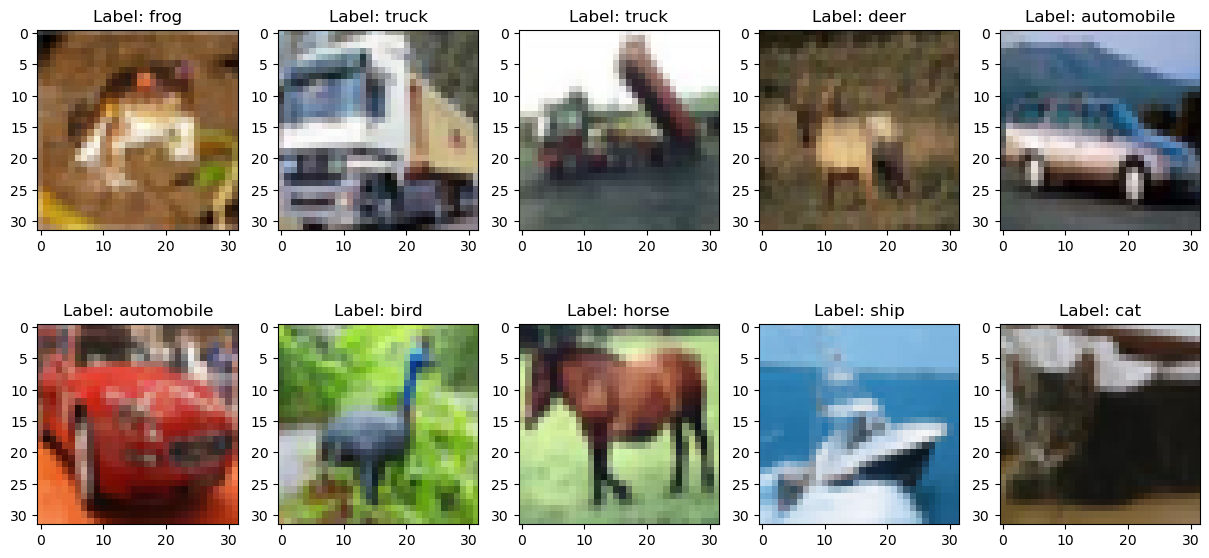

In [4]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {class_name[label.argmax()]}",  fontsize=12)

# **Training Model**

Create a ResNet-18 model using Keras API. ResNet-18 is a convolutional neural network with 18 layers, designed to address the vanishing gradient problem using residual blocks. These blocks include shortcut connections that allow gradients to flow more easily during training, making it effective for image classification tasks. Afterwards, the model is compiled with an optimizer, loss function, and metrics.

In [5]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

b2 = ResnetBlock(64, 2, first_block=True,)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

def net():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=10, activation='softmax')])

    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer=tf.optimizers.legacy.Adam(learning_rate=0.0001)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

In [6]:
model = net()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  (None, 16, 16, 64)        148736    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 8, 8, 128)        5

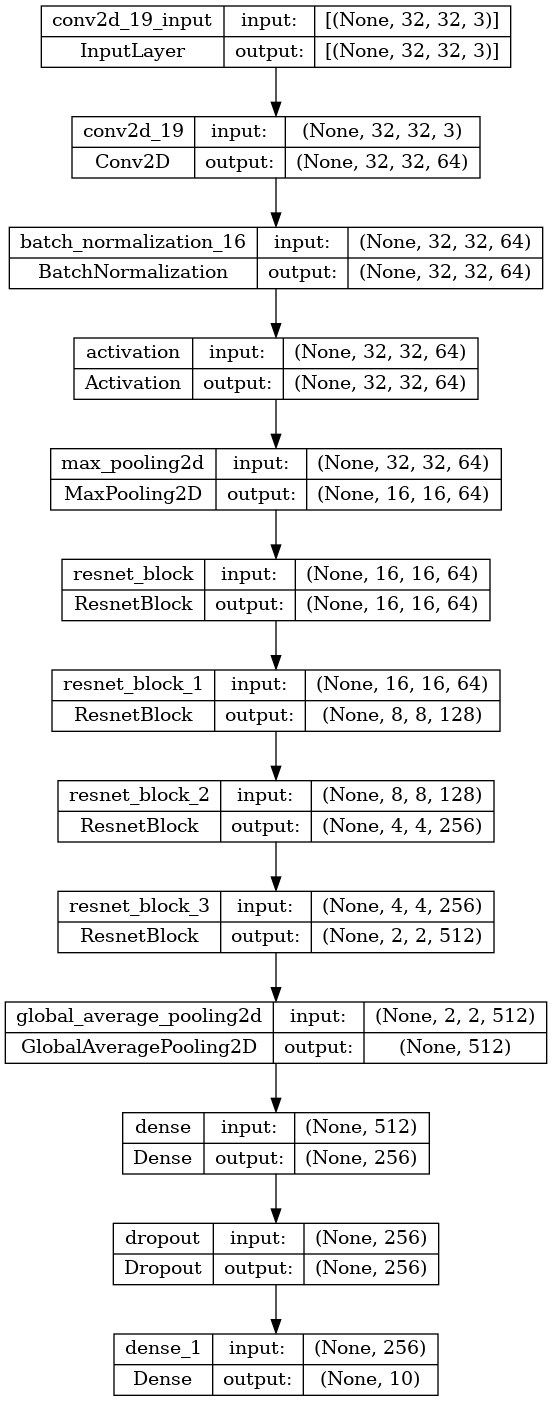

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Fit the model on training data.

In [8]:
# history = model.fit(x_train, y_train, batch_size=32, epochs = 50)
# Save/Load the model 
# model.save('./../models/cifar10_resnet18.tf')
model = tf.keras.models.load_model('./../models/cifar10_resnet18.tf')
model.summary()

2024-05-29 11:02:19.400679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 641 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-05-29 11:02:19.582685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2024-05-29 11:02:19.972129: W tensorflow/c/c_api.cc:291] Operation '{name:'AssignVariableOp_195' id:3466 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_195}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](gamma_11, Identity_195)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  (None, 16, 16, 64)        148736    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 8, 8, 128)        5

#### Evaluate model accuracy on test data.

In [9]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-29 11:02:25.164311: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:3787 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-29 11:02:26.164753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-05-29 11:02:26.737225: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 662.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-29 11:02:26.763899: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out

Accuracy on test data: 75.09%


2024-05-29 11:02:34.610028: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 611.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-29 11:02:34.630013: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 619.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-29 11:02:34.630045: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 619.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-29 11:02:34.631202: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocato

In [10]:
x_test_pred = np.argmax(model.predict(x_test), axis = 1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis = 1))

print('Original test Data: ')
print('Correctly Classified: {}'.format(nb_correct_pred))
print('Incorrectly Classified: {}'.format(len(x_test) - nb_correct_pred))

2024-05-29 11:02:36.870486: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/Softmax' id:3711 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Original test Data: 
Correctly Classified: 7509
Incorrectly Classified: 2491


In [10]:
x_test = x_test[0:100]
y_test = y_test[0:100]

In [12]:
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0))

### **Zeroth-Order Optimization (ZOO) Attack**

> class art.attacks.evasion.ZooAttack(classifier: CLASSIFIER_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, max_iter: int = 10, binary_search_steps: int = 1, initial_const: float = 0.001, abort_early: bool = True, use_resize: bool = True, use_importance: bool = True, nb_parallel: int = 128, batch_size: int = 1, variable_h: float = 0.0001, verbose: bool = True)

The black-box zeroth-order optimization attack from Pin-Yu Chen et al. (2018). This attack is a variant of the C&W attack which uses ADAM coordinate descent to perform numerical estimation of gradients.
* Paper link: https://arxiv.org/abs/1708.03999

*__init__(classifier: CLASSIFIER_TYPE, confidence: float = 0.0, targeted: bool = False, learning_rate: float = 0.01, max_iter: int = 10, binary_search_steps: int = 1, initial_const: float = 0.001, abort_early: bool = True, use_resize: bool = True, use_importance: bool = True, nb_parallel: int = 128, batch_size: int = 1, variable_h: float = 0.0001, verbose: bool = True)*

**Create a ZOO attack instance.**

**Parameters**

* classifier – A trained classifier.
* confidence (float) – Confidence of adversarial examples: a higher value produces examples that are farther away, from the original input, but classified with higher confidence as the target class.
* targeted (bool) – Should the attack target one specific class.
* learning_rate (float) – The initial learning rate for the attack algorithm. Smaller values produce better results but are slower to converge.
* max_iter (int) – The maximum number of iterations.
* binary_search_steps (int) – Number of times to adjust constant with binary search (positive value).
* initial_const (float) – The initial trade-off constant c to use to tune the relative importance of distance and confidence. If binary_search_steps is large, the initial constant is not important, as discussed in Carlini and Wagner (2016).
* abort_early (bool) – True if gradient descent should be abandoned when it gets stuck.
* use_resize (bool) – True if to use the resizing strategy from the paper: first, compute attack on inputs resized to 32x32, then increase size if needed to 64x64, followed by 128x128.
* use_importance (bool) – True if to use importance sampling when choosing coordinates to update.
* nb_parallel (int) – Number of coordinate updates to run in parallel. A higher value for nb_parallel should be preferred over a large batch size.
* batch_size (int) – Internal size of batches on which adversarial samples are generated. Small batch sizes are encouraged for ZOO, as the algorithm already runs nb_parallel coordinate updates in parallel for each sample. The batch size is a multiplier of nb_parallel in terms of memory consumption.
* variable_h (float) – Step size for numerical estimation of derivatives.
* verbose (bool) – Show progress bars.

> generate(x: ndarray, y: Optional[ndarray] = None, **kwargs) → ndarray

**Generate adversarial samples and return them in an array.**

**Return type**
* ndarray

**Parameters**
* x (ndarray) – An array with the original inputs to be attacked.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,).

**Returns**
* An array holding the adversarial examples.

**Link**
documetation: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#zeroth-order-optimization-zoo-attack
github: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/attacks/evasion/zoo.py

### Create an ART ZOO attack.

In [13]:
zoo_attack = ZooAttack(classifier = classifier,
                       learning_rate=0.1,
                       targeted = False,
                       max_iter = 500,
                       verbose = True, 
                       batch_size=32, 
                       nb_parallel=32)

#### Generate adversarial test data.

In [14]:
# x_test_adv = zoo_attack.generate(x_test, y=y_test)
# np.savez('./ZOO_data/ZOO_generated_cifar_test_data.npz', x_test_adv = x_test_adv, y_test = y_test)
test_data = np.load('./ZOO_data/ZOO_generated_cifar_test_data.npz')
x_test_adv, y_test = test_data['x_test_adv'], test_data['y_test']
x_test_adv.shape, y_test.shape

((100, 32, 32, 3), (100, 10))

Visualise the first adversarial test sample.

2024-05-29 11:03:34.794290: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 563.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-29 11:03:34.813441: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 602.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


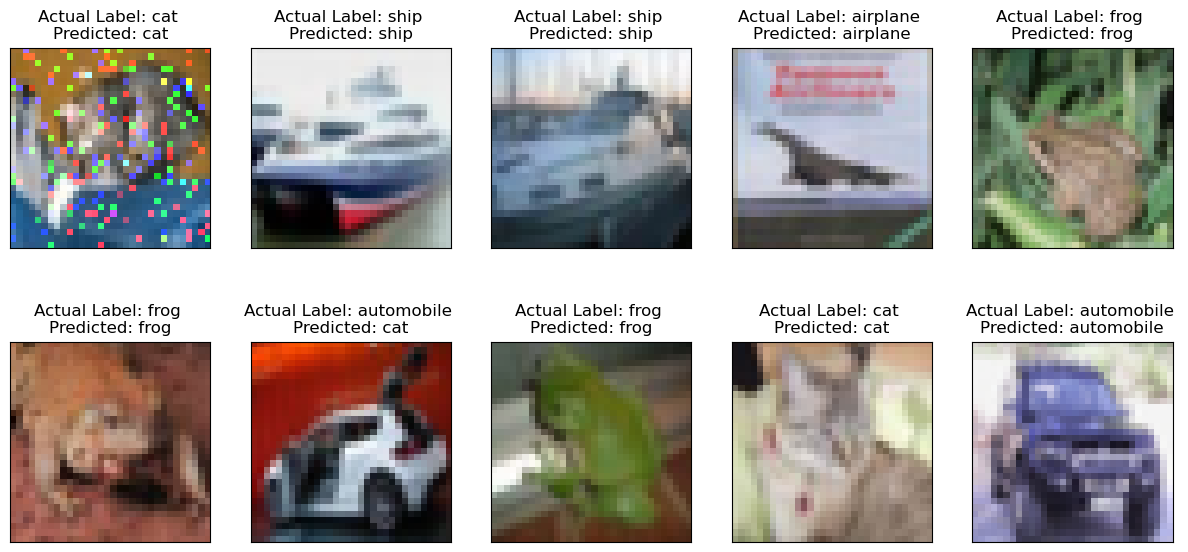

In [15]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {class_name[label.argmax()]} \nPredicted: {class_name[model.predict(np.expand_dims(image, axis=0)).argmax()]}",  fontsize=12)


#### Evaluate the trained model

In [16]:
x_test_pred = np.argmax(model.predict(x_test_adv), axis = 1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis = 1))

print('Original test Data: ')
print('Correctly Classified: {}'.format(nb_correct_pred))
print('Incorrectly Classified: {}'.format(len(x_test) - nb_correct_pred))

Original test Data: 
Correctly Classified: 76
Incorrectly Classified: 9924


Training the Detector

We create the second model using Keras API with the same strucure of the classifier. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics. This model will be used to classify between ordinary samples and perturbated ones

In [17]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

b2 = ResnetBlock(64, 2, first_block=True,)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

def detector():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=2, activation='softmax')])

    loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    optimizer=tf.optimizers.legacy.Adam(learning_rate=0.0001)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

In [18]:
detector_model = detector()
# tf.keras.utils.plot_model( model = detector_model, show_shapes = True)

#### Generate Adversarial samples for training the detector model. 

In [14]:
# Generating adversarail training data is time taking process. 
# So, we have decreased the number of samples to 500 to save time, 
# if you do not want to generate yourself, we have the saved data for your in the next chunk of cells. 
x_train_adv = zoo_attack.generate(x_train[:500])
nb_train = x_train[:500].shape[0]

x_train_detector = np.concatenate((x_train[:500], x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

ZOO: 100%|██████████| 16/16 [48:48<00:00, 183.02s/it]


In [19]:
# np.savez('./ZOO_data/ZOO_generated_cifar_detector.npz', x_train_detector = x_train_detector, y_train_detector = y_train_detector)
detector_data = np.load('./ZOO_data/ZOO_generated_cifar_detector.npz')
x_train_detector, y_train_detector = detector_data['x_train_detector'], detector_data['y_train_detector']
x_train_detector.shape, y_train_detector.shape

((1000, 32, 32, 3), (1000, 2))

Note: the robust classifier has the same architecture as above, except the first dense layer has 1024 instead of 128 units. (This was recommend by Madry et al. (2017), Towards Deep Learning Models Resistant to Adversarial Attacks)

In [21]:
detector_model.fit(x_train_detector, y_train_detector, batch_size=32, epochs=10)

#### Evaluate the adversarial generated data

In [127]:
x_test = x_test[:100]
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)

In [128]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 63.50%


In [109]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [110]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

### Evaluating the detector

Apply the detector to the adversarial test data:

In [129]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(100 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 27
Not flagged: 73


Apply the detector to the first 100 original test images:

In [130]:
_, is_adversarial = detector.detect(x_test)
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 0
Not flagged: 100


Evaluate the robust classifier's performance on the adversarial test data (black-box setting):

In [134]:
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]
nb_flag_adv = []
nb_missclass = []


zoo_attack.set_params(**{'max_iter' : 10})

for rate in learning_rate:
    zoo_attack.set_params(**{'learning_rate': rate})
    x_test_adv = zoo_attack.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

learning_range = [0] + learning_rate
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

ZOO:   0%|          | 0/4 [00:00<?, ?it/s]

ZOO: 100%|██████████| 4/4 [02:02<00:00, 30.74s/it]


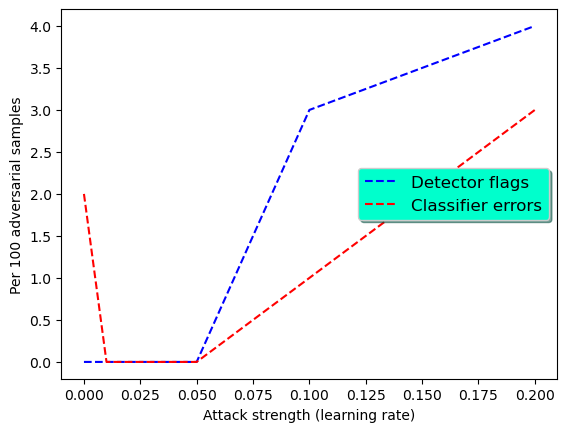

In [135]:
fig, ax = plt.subplots()
ax.plot(np.array(learning_range)[:8], np.array(nb_flag_adv)[:8], 'b--', label='Detector flags')
ax.plot(np.array(learning_range)[:8], np.array(nb_missclass)[:8], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (learning rate)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

Evaluate the adversarial generated data

### **Summary**


#### Zeroth-Order Optimization (ZOO) Attack and Binary Input Detector Using CIFAR-10

This notebook demonstrates the implementation of the ZOO attack using the Adversarial Robustness Toolbox (ART) against deep learning models trained on the CIFAR-10 dataset. The tasks covered include:

1. **Load the Required Libraries:** Import necessary Python libraries and modules, including TensorFlow/Keras and ART.
2. **Load the Dataset and Inspect the Data:** Load and visualize the CIFAR-10 dataset.
3. **Create a Deep Learning Model:** Construct and compile a ResNet-18 model.
4. **Train and Evaluate the Model:** Train the model on CIFAR-10 and evaluate its accuracy.
5. **Implement ZOO Attack Using ART:** The Zeroth Order Optimization (ZOO) attack is notable for its effectiveness in black-box settings, where only the model's output is accessible.
6. **Create Adversarial Samples Using ZOO:** Generate adversarial examples from the test images using ZOO and visually inspect them.
7. **Evaluate Against Adversarial Samples:** Test the model's robustness by evaluating its accuracy on the adversarial samples.
8. **Create a Detector Model:** Develop a binary classifier to detect adversarial inputs by differentiating between original and adversarial images.
9. **Train and Evaluate the Detector:** Train the detector using a labeled dataset of original and adversarial samples, and evaluate its accuracy in identifying adversarial attacks.

This summary highlights the process and key tasks involved in implementing the ZOO attack and developing a binary input detector using the CIFAR-10 dataset, illustrating the importance of adversarial defenses in machine learning.